In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm
import scipy.stats as stats

## 1. Wizualizacja danych

Zbadanie jakości danych (detekcja wartości spoza zakładanego przedziału, identyfikacja ewentualnych
braków w danych lub błędów w próbkowaniu)

STATION         0
NAME            0
LATITUDE        0
LONGITUDE       0
ELEVATION       0
DATE            0
PRCP         1796
SNWD         9531
TAVG            0
TMAX         3491
TMIN         5084
dtype: int64
Minimum z próby:  -22.3 Maksimum z próby:  29.1


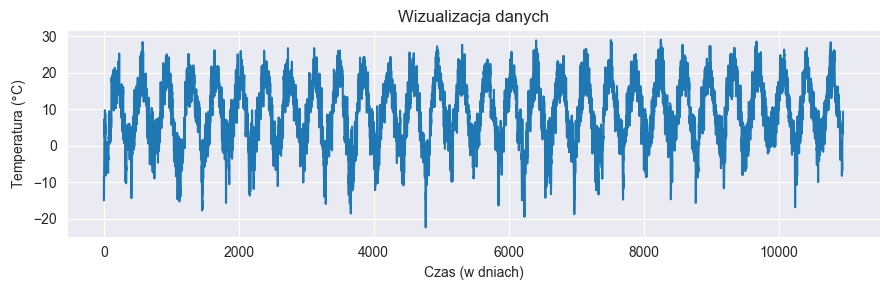

In [41]:
df = pd.read_csv(r'..\data\warsaw.csv')
avg_temp = df['TAVG']


# Informacje o brakach w danych
print(df.isnull().sum())
print('Minimum z próby: ', min(avg_temp),'Maksimum z próby: ', max(avg_temp))

# Wizualizacja trajektorii

plt.figure(figsize=(9, 3))

plt.plot(avg_temp)
plt.xlabel('Czas (w dniach)')
plt.ylabel(r'Temperatura ($\degree$C)')
plt.title('Wizualizacja danych')

plt.tight_layout()
plt.savefig("..\\img\\wizualizacja_danych.png")
plt.show()
plt.close()

### Funkcje ACF i PACF dla surowych danych

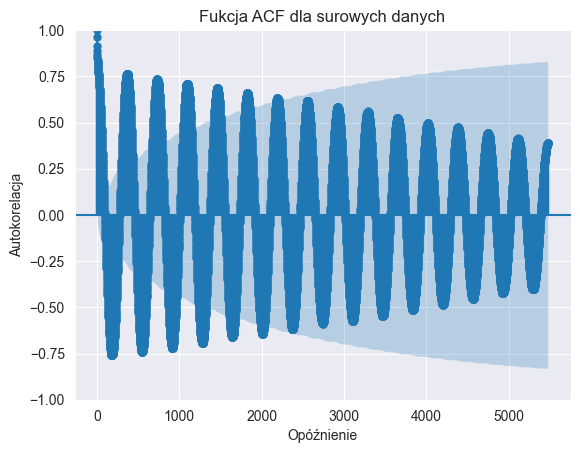

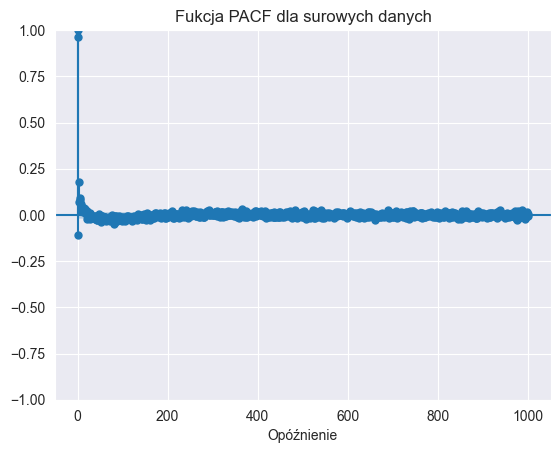

In [3]:
n = len(avg_temp)
lags = np.arange(0, n // 2)

plot_acf(avg_temp, lags=lags)                       # Wykres z użyciem funkcji bibliotecznej
plt.title('Fukcja ACF dla surowych danych')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.show()

plot_pacf(avg_temp, lags=1000)
plt.title('Fukcja PACF dla surowych danych')
plt.xlabel('Opóźnienie')
plt.show()

## 2. Dekompozycja 

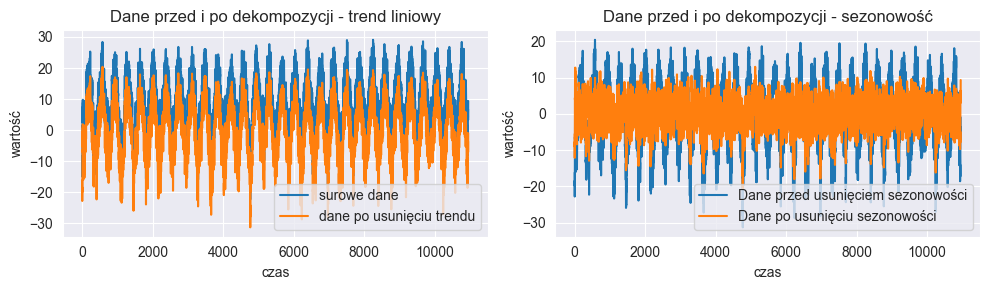

In [3]:
# Usuwanie trendu liniowego

time = np.arange(len(avg_temp))

linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), avg_temp)
trend_predicted = linear_reg.predict(time.reshape(-1, 1))

avg_temp_without_linear_trend = avg_temp - trend_predicted

# Usuwanie funkcji okresowej

def sine_func(x, A, omega, phi):
    return A * np.sin(omega * x + phi)

p0 = [(max(avg_temp) - min(avg_temp)/2), 2 * np.pi / 365, np.pi / 2]
params, _ = curve_fit(sine_func, time, avg_temp_without_linear_trend, p0=p0)
fitted_sine_wave = sine_func(time, *params)

avg_temp_without_seasonal = avg_temp_without_linear_trend - fitted_sine_wave

# Wykresy dla danych

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(avg_temp, label='surowe dane')
axes[0].plot(avg_temp_without_linear_trend, label='dane po usunięciu trendu')
axes[0].set_xlabel('czas')
axes[0].set_ylabel('wartość')
axes[0].set_title('Dane przed i po dekompozycji - trend liniowy')
axes[0].legend()

# Plot the original ARMA process and the ARMA process without seasonal trend
axes[1].plot(avg_temp_without_linear_trend, label='Dane przed usunięciem sezonowości')
axes[1].plot(avg_temp_without_seasonal, label='Dane po usunięciu sezonowości')
axes[1].set_xlabel('czas')
axes[1].set_ylabel('wartość')
axes[1].set_title('Dane przed i po dekompozycji - sezonowość')
axes[1].legend()

plt.tight_layout()
plt.show()

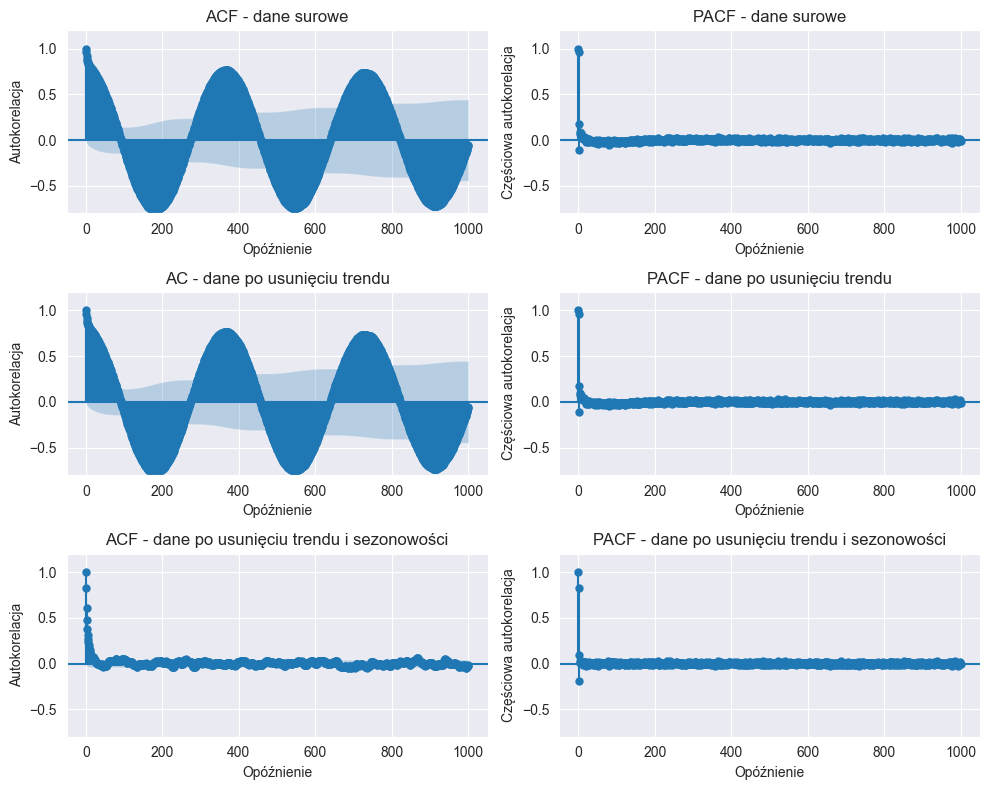

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

plot_acf(avg_temp, lags=1000, ax=axes[0, 0])
axes[0, 0].set_xlabel('Opóźnienie')
axes[0, 0].set_ylabel('Autokorelacja')
axes[0, 0].set_title('ACF - dane surowe')
axes[0, 0].set_ylim(-0.8, 1.2)

plot_pacf(avg_temp, lags=1000, ax=axes[0, 1])
axes[0, 1].set_xlabel('Opóźnienie')
axes[0, 1].set_ylabel('Częściowa autokorelacja')
axes[0, 1].set_title('PACF - dane surowe')
axes[0, 1].set_ylim(-0.8, 1.2)

plot_acf(avg_temp_without_linear_trend, lags=1000, ax=axes[1, 0])
axes[1, 0].set_xlabel('Opóźnienie')
axes[1, 0].set_ylabel('Autokorelacja')
axes[1, 0].set_title('AC - dane po usunięciu trendu')
axes[1, 0].set_ylim(-0.8, 1.2)

plot_pacf(avg_temp_without_linear_trend, lags=1000, ax=axes[1, 1])
axes[1, 1].set_xlabel('Opóźnienie')
axes[1, 1].set_ylabel('Częściowa autokorelacja')
axes[1, 1].set_title('PACF - dane po usunięciu trendu')
axes[1, 1].set_ylim(-0.8, 1.2)

plot_acf(avg_temp_without_seasonal, lags=1000, ax=axes[2, 0])
axes[2, 0].set_xlabel('Opóźnienie')
axes[2, 0].set_ylabel('Autokorelacja')
axes[2, 0].set_title('ACF - dane po usunięciu trendu i sezonowości')
axes[2, 0].set_ylim(-0.8, 1.2)

plot_pacf(avg_temp_without_seasonal, lags=1000, ax=axes[2, 1])
axes[2, 1].set_xlabel('Opóźnienie')
axes[2, 1].set_ylabel('Częściowa autokorelacja')
axes[2, 1].set_title('PACF - dane po usunięciu trendu i sezonowości')
axes[2, 1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

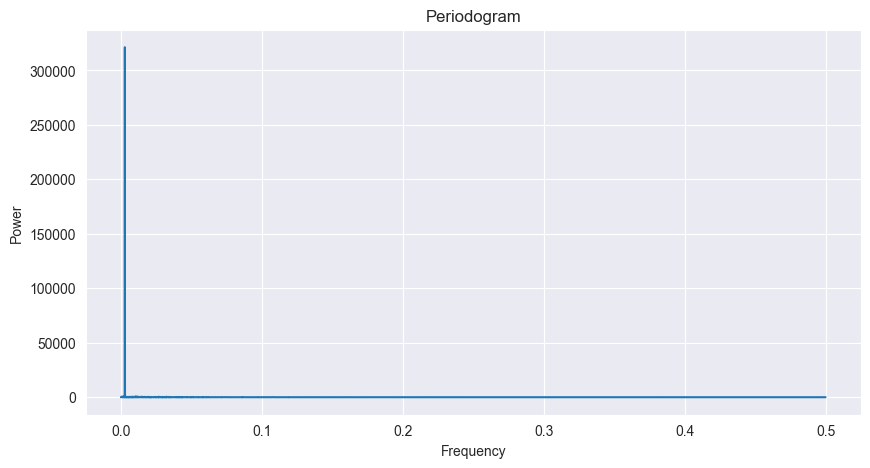

Top 5 Peaks (Frequency, Period):
Peak 1: 0.0027, 365.13
Peak 2: -0.0027, -365.13
Peak 3: 0.0024, 421.31
Peak 4: -0.0024, -421.31
Peak 5: 0.0105, 95.25
Peak 6: -0.0105, -95.25


In [4]:
# Periodogram

periodogram = np.abs(np.fft.fft(avg_temp_without_linear_trend))**2 / len(avg_temp_without_linear_trend)
frequencies = np.fft.fftfreq(len(avg_temp_without_linear_trend))

plt.figure(figsize=(10, 5))
plt.plot(frequencies[:len(avg_temp_without_linear_trend) // 2], periodogram[:len(avg_temp_without_linear_trend) // 2])
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

peak_indices = np.argsort(periodogram)[::-1][:6] 
peaks_frequency = frequencies[peak_indices]
peaks_period = 1 / peaks_frequency

print("Top 5 Peaks (Frequency, Period):")
for i in range(len(peaks_frequency)):
    print(f"Peak {i+1}: {peaks_frequency[i]:.4f}, {peaks_period[i]:.2f}")

### Dekompozycja - wersja 2

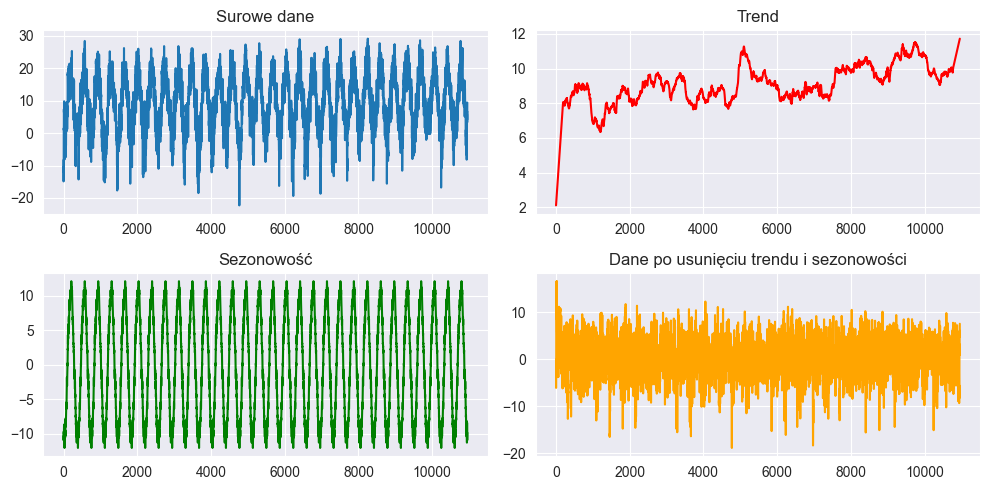

In [5]:
decomposition = seasonal_decompose(avg_temp, model='additive', period=365, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(avg_temp, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### Dekompozycja - wersja 3

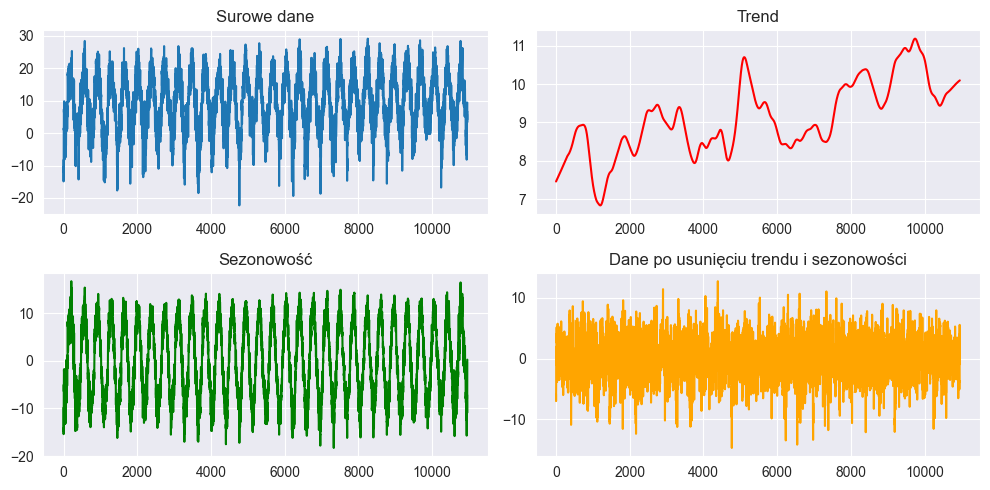

In [6]:
# https://otexts.com/fpp2/stl.html

stl_decomposition = STL(avg_temp, period=365).fit()

trend_stl = stl_decomposition.trend
seasonal_stl = stl_decomposition.seasonal
residual_stl = stl_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(avg_temp, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_stl, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_stl, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_stl, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### Dekompozycja - wersja 4

C:\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


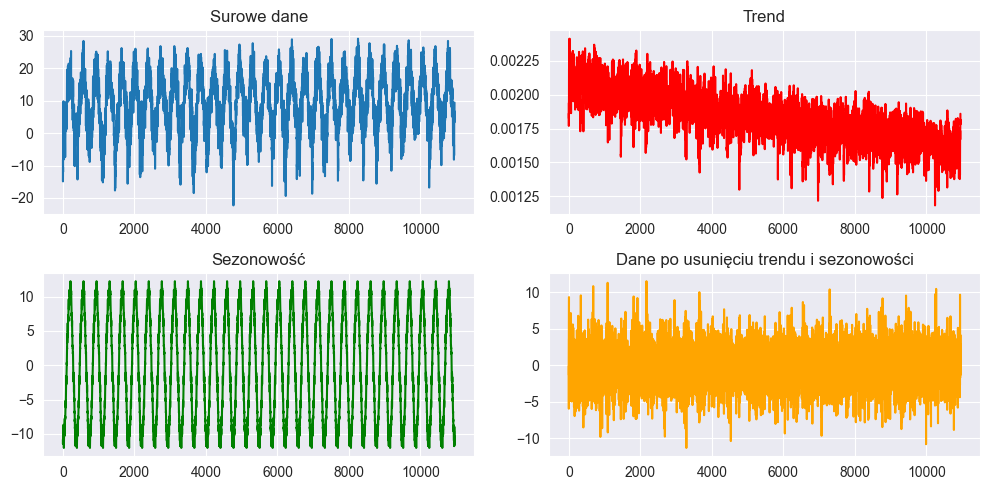

In [7]:
# https://otexts.com/fpp2/holt-winters.html

ets_model = ExponentialSmoothing(avg_temp, seasonal_periods=365, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(avg_temp, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [8]:
average_temperature_after_decomposition1 = avg_temp_without_seasonal
average_temperature_after_decomposition2 = residual
average_temperature_after_decomposition3 = residual_stl
average_temperature_after_decomposition4 = residual_ets

# Sprawdzenie stacjonarności
adf_test1 = adfuller(average_temperature_after_decomposition1)
adf_test2 = adfuller(average_temperature_after_decomposition2)
adf_test3 = adfuller(average_temperature_after_decomposition3)
adf_test4 = adfuller(average_temperature_after_decomposition4)
print("ADF test p-value:", adf_test1[1])
print("ADF test p-value:", adf_test2[1])
print("ADF test p-value:", adf_test3[1])
print("ADF test p-value:", adf_test4[1])

ADF test p-value: 0.0
ADF test p-value: 0.0
ADF test p-value: 3.239476186651376e-30
ADF test p-value: 0.0


In [13]:
# Za pomocą kryteriow informacyjnych szukamy rzędu modelu

def inf_criteria(arma_process_trajectory, max_p=5, max_q=5):
    df = pd.DataFrame()
    
    ps = []
    qs = []
    BIC = []
    AIC = []
    HQIC = []

    
    # Iteracja po możliwych wartościach p i q
    for p in range(0, max_p):
        for q in range(0, max_q):
            
            # Dopasowanie modelu ARMA dla danego p i q
            model = ARIMA(arma_process_trajectory, order=(p, 0, q))
            model_fit = model.fit()
            
            # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
            ps.append(p)
            qs.append(q)
            AIC.append(model_fit.aic)
            BIC.append(model_fit.bic)
            HQIC.append(model_fit.hqic)
    
    df['p']    = ps
    df['q']    = qs
    df['AIC']  = AIC
    df['BIC']  = BIC
    df['HQIC'] = HQIC
    return df

In [14]:
df1 = inf_criteria(average_temperature_after_decomposition1)

C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: 

In [15]:
df1.sort_values(by='AIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,48623.466105,48667.274865,48638.228162


In [16]:
df1.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,48623.466105,48667.274865,48638.228162


In [17]:
df1.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,48623.466105,48667.274865,48638.228162


In [18]:
df2 = inf_criteria(average_temperature_after_decomposition2)

C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: 

In [19]:
df2.sort_values(by='AIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,48273.755193,48317.563953,48288.517249


In [20]:
df2.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,48273.755193,48317.563953,48288.517249


In [21]:
df2.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,48273.755193,48317.563953,48288.517249


In [10]:
# Automatyczny dobór modelu ARMA
model = pm.auto_arima(average_temperature_after_decomposition1, seasonal=False, trace=True, information_criterion='bic')
print(model.summary())

# Dopasowanie wybranego modelu
final_model = ARIMA(average_temperature_after_decomposition1, order=model.order)
results = final_model.fit()

# Podsumowanie wyników
# print(results.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=48657.974, Time=2.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=61434.348, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=49160.207, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=53209.456, Time=0.68 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=48676.255, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=48679.477, Time=0.50 sec


KeyboardInterrupt: 

In [23]:
model = pm.auto_arima(average_temperature_after_decomposition2, seasonal=False, trace=True, information_criterion='aic')
print(model.summary())

final_model = ARIMA(average_temperature_after_decomposition2, order=model.order)
results = final_model.fit()

# print(results.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=48271.897, Time=4.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61016.025, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=48792.424, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=52811.824, Time=1.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=48296.685, Time=0.92 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=48299.575, Time=0.98 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=48273.382, Time=7.93 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=48273.443, Time=4.36 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=48307.083, Time=0.48 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=48288.024, Time=1.50 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=48288.502, Time=3.46 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=48274.323, Time=4.69 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=48273.901, Time=17.30 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 47.790 seconds
       

In [9]:
p, q = 2, 2

model_first_method = ARIMA(average_temperature_after_decomposition1, order=(p, 0, q)).fit(method='statespace')
model_second_method = ARIMA(average_temperature_after_decomposition1, order=(p, 0, q)).fit(method='innovations_mle')
model_third_method = ARIMA(average_temperature_after_decomposition1, order=(p, 0, q)).fit(method='hannan_rissanen')

print("Wyniki dla method='statespace':\n")
print(model_first_method.summary())
print("\n")
print("Wyniki dla method='innovations_mle':\n")
print(model_second_method.summary())
print("\n")
print("Wyniki dla method='hannan_rissanen':\n")
print(model_third_method.summary())

Wyniki dla method='statespace':

                               SARIMAX Results                                
Dep. Variable:                   TAVG   No. Observations:                10954
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -24305.733
Date:                Fri, 31 Jan 2025   AIC                          48623.466
Time:                        18:42:31   BIC                          48667.275
Sample:                             0   HQIC                         48638.228
                              - 10954                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.125     -0.028      0.977      -0.248       0.241
ar.L1          1.5030      0.056     26.849      0.000       1.393       1.613
ar.L2         -0.54

In [12]:
print(model_first_method.params[1:-1])
# print(model_second_method.params[1:-1])
# print(model_third_method.params[1:-1])

ar.L1    1.503007
ar.L2   -0.544533
ma.L1   -0.507979
ma.L2   -0.249146
dtype: float64


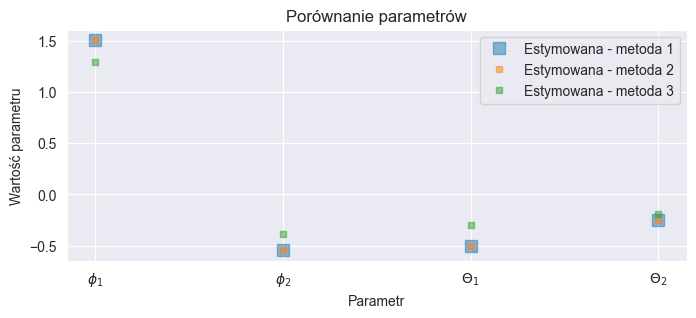

In [13]:
plt.figure(figsize=(8,3))

plt.plot(model_first_method.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.plot(model_second_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 2')
plt.plot(model_third_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 3')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')
plt.xticks(range(4), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])

plt.show()

## Ocena dopasowania modelu

In [27]:
# TODO

## Weryfikacja założeń dotyczących szumu

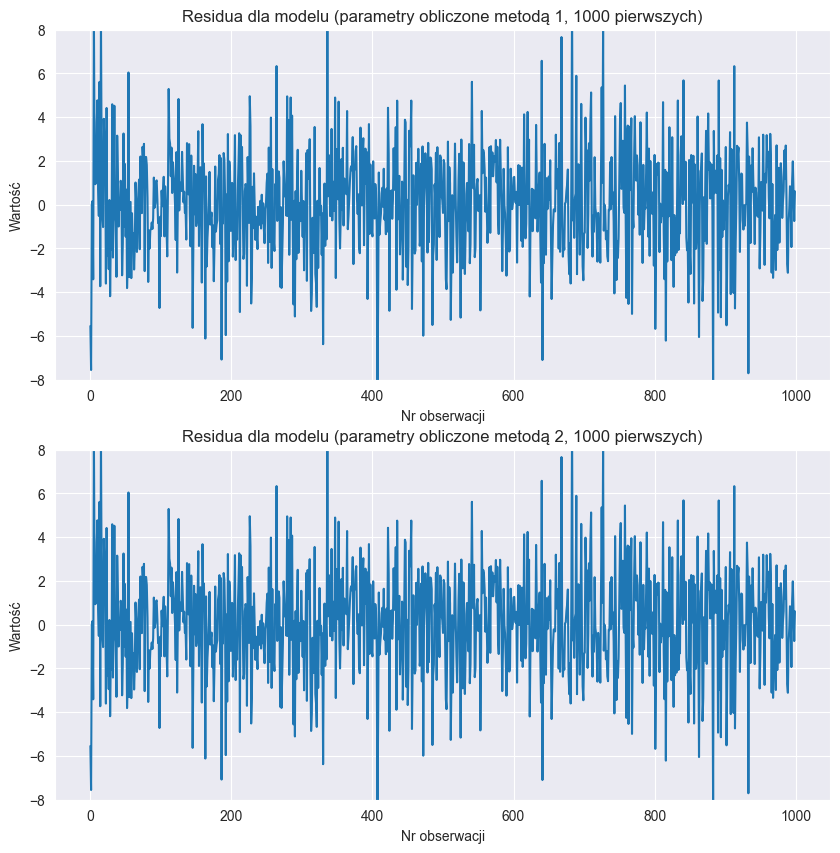

In [25]:
# Wyznaczanie residuów na podstawie dopasowanego modelu
resid_1 = model_first_method.resid
resid_2 = model_second_method.resid

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(resid_1[:1000])
plt.title('Residua dla modelu (parametry obliczone metodą 1, 1000 pierwszych)')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-8, 8])

plt.subplot(2, 1, 2)
plt.plot(resid_2[:1000])
plt.title('Residua dla modelu (parametry obliczone metodą 2, 1000 pierwszych)')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-8, 8])

plt.show()

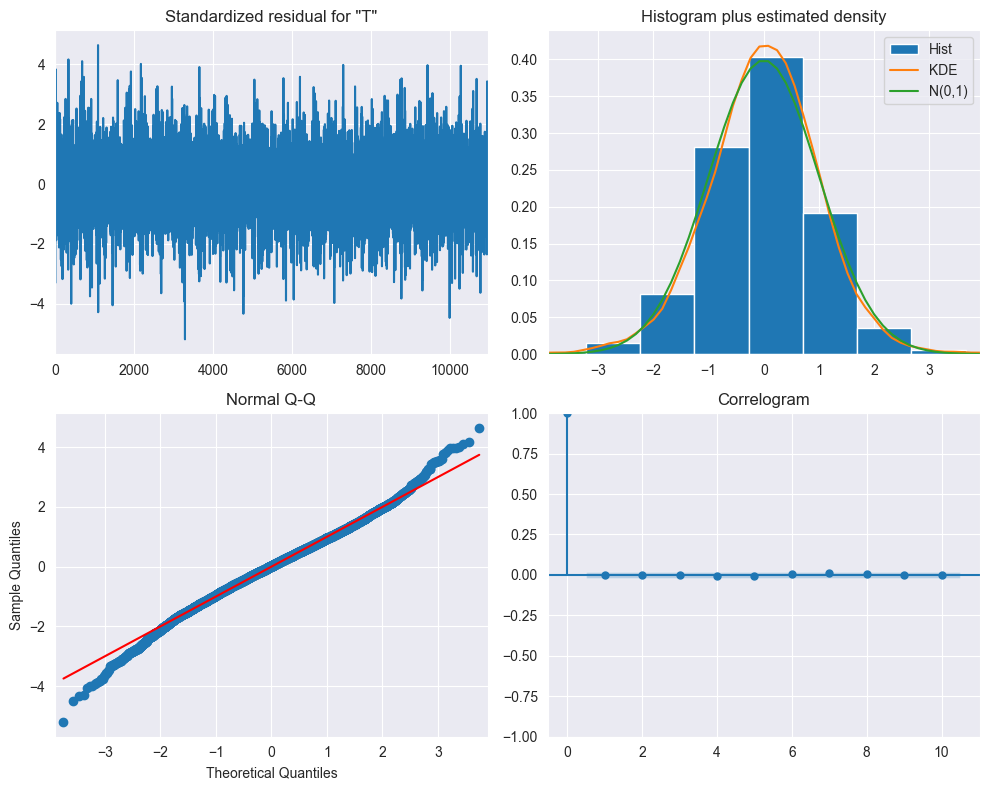

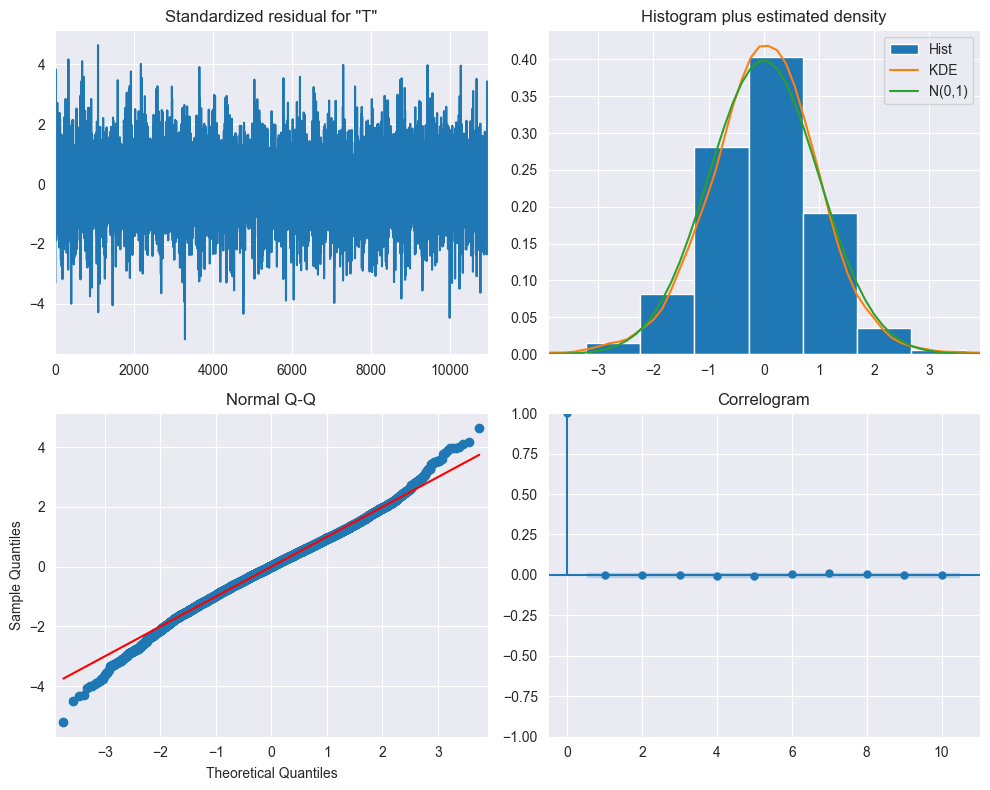

In [11]:
# Wbudowana funkcja do podstowej diagnostyki modelu
model_first_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

model_second_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

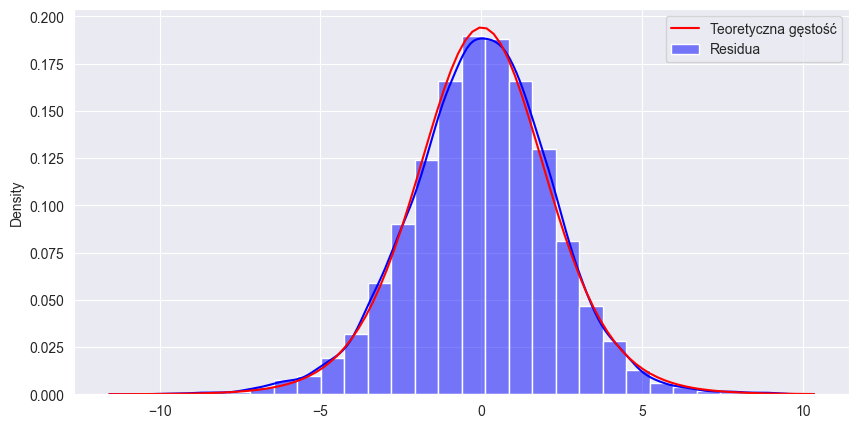

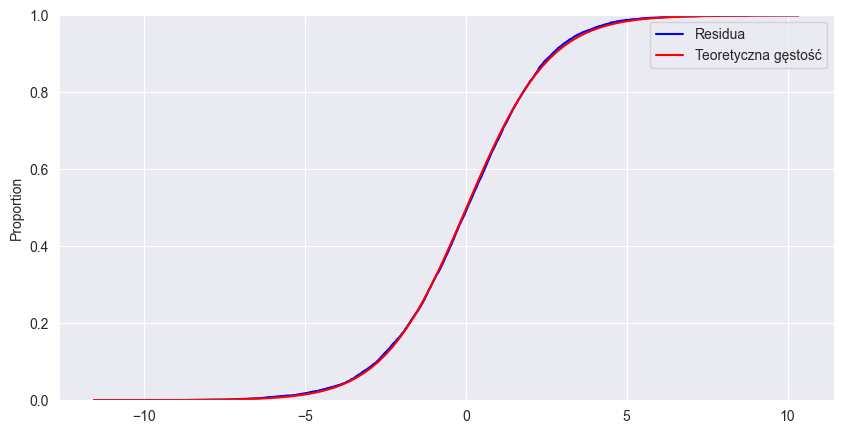

Statystyka testowa: 0.0088, p-wartość: 0.3567


In [43]:
# Histogram i KDE
plt.figure(figsize=(10, 5))
sns.histplot(resid_1, kde=True, bins=30, stat="density", label="Residua", color="blue")

# Dopasowanie rozkładu t-Studenta
params = stats.t.fit(resid_1)
x = np.linspace(min(resid_1), max(resid_1), 100)
pdf_fitted = stats.t.pdf(x, *params)

cdf_fitted = stats.t.cdf(x, *params)

# Narysowanie teoretycznej gęstości
plt.plot(x, pdf_fitted, 'r-', label="Teoretyczna gęstość")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.ecdfplot(resid_1, label="Residua", color="blue")
plt.plot(x, cdf_fitted, 'r-', label="Teoretyczna gęstość" )
plt.legend()
plt.show()

df, loc, scale = params

ks_statistic, p_value = stats.kstest(resid_1, 't', args=params)
print(f"Statystyka testowa: {ks_statistic:.4f}, p-wartość: {p_value:.4f}")

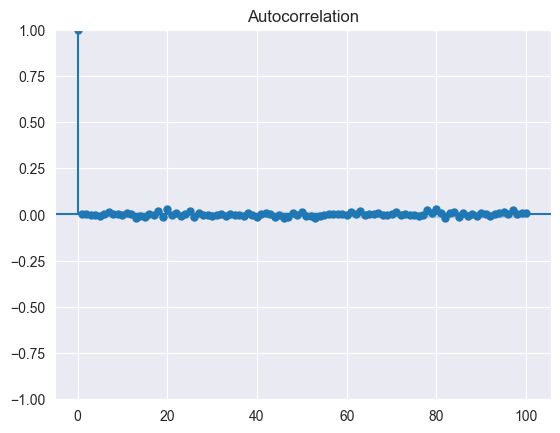

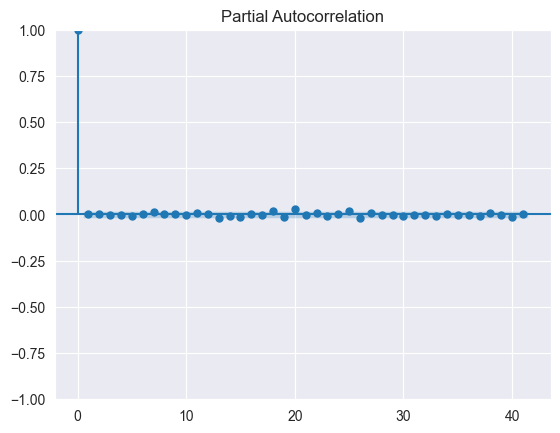

In [34]:
plot_acf(resid_1, lags=100)
plt.show()

plot_pacf(resid_1)
plt.show()

In [35]:
# Przykładowy podział na dwie grupy
group1 = resid_1[:len(resid_1)//2]  # pierwsza połowa
group2 = resid_1[len(resid_1)//2:]  # druga połowa

stat, p = stats.levene(group1, group2)
print(f"Levene’s Test p-value: {p}")

stat, p = stats.fligner(group1, group2)
print(f"Fligner-Killeen Test p-value: {p}")

Levene’s Test p-value: 0.8866764752765504
Fligner-Killeen Test p-value: 0.9797147530858552


In [50]:
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan

# Dodaj kolumnę stałych do exog
exog = np.column_stack((np.ones(len(resid_1)), model_first_method.model.exog))

# Test Breuscha-Pagana
stat, p_value, _, _ = het_breuschpagan(resid_1, exog)
print(f"Statystyka testowa: {stat:.4f}, p-wartość: {p_value:.4f}")

stat, p_value, _, _ = het_breuschpagan(resid_1, exog, robust=True)
print(f"Statystyka testowa: {stat:.4f}, p-wartość: {p_value:.4f}")

Statystyka testowa: -10.0097, p-wartość: 1.0000
Statystyka testowa: -10.0097, p-wartość: 1.0000


In [45]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Test Goldfelda-Quandta
resid = resid_1  # Residua z modelu ARMA
exog = model_first_method.model.exog  # Zmienne objaśniające (macierz X)

stat, p_value, _ = het_goldfeldquandt(resid, exog)
print(f"Statystyka testowa: {stat:.4f}, p-wartość: {p_value:.4f}")

Statystyka testowa: 0.9732, p-wartość: 0.8424


In [46]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Test Koenckera-Bassetta (wersja robust)
resid = resid_1  # Residua z modelu ARMA
exog = model_first_method.model.exog  # Zmienne objaśniające (macierz X)

stat, p_value, _, _ = het_breuschpagan(resid, exog, robust=True)
print(f"Statystyka testowa: {stat:.4f}, p-wartość: {p_value:.4f}")

ValueError: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

In [47]:
from statsmodels.stats.diagnostic import het_arch

# Test ARCH-LM
resid = resid_1  # Residua z modelu ARMA

stat, p_value, _, _ = het_arch(resid)
print(f"Statystyka testowa: {stat:.4f}, p-wartość: {p_value:.4f}")

Statystyka testowa: 181.7022, p-wartość: 0.0000
